In [1]:
from sim_env import FixedSimEnv
from main import run_ehd, flag_departure_event, recommended_dep_t, ehd_message, td
from copy import deepcopy
import pandas as pd
import numpy as np
from data_handlers import GTFSHandler, AVLHandler, bpf, write_sim_data, ODXHandler
from itertools import product
from constants import *
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
from utils import plot_situation

In [2]:
env = FixedSimEnv()
unique_dates = env.link_times['date'].unique()
day = np.random.choice(unique_dates, replace=False)

next_obs, rew, done, info = env.reset(hist_date='2022-12-05')
print(env.hist_date)

2022-12-05


In [3]:
info[0].head(1)

,time,nr_step,route_id,block_id,direction,active,status,status_desc,next_event,next_event_t,t_until_next,stop_id,stop_sequence,pax_load,t_since_last,trip_id,trip_sequence
0,05:06:50.7,2,81,652000002769,East,0,4,inactive - reported for first trip,terminal boarding,05:08:30.0,99.3,14102,1,0,0.0,6279020,1


In [4]:
def check_for_interlining(rt_info, time, max_delay):
    missing_trip_exists = rt_info.loc[2, 'confirmed'] == 0
    within_otp_of_missing = rt_info.loc[2, 'ST'] + max_delay > time
    return missing_trip_exists and within_otp_of_missing

def run_di(env, done, n_steps=0, debug=False, interlining_opps=0):
    while not done and n_steps < MAX_STEPS:
        next_obs, rew, done, info = env.step()
        n_steps += 1
        if done:
            continue

        control_vehs = flag_departure_event(info[1])

        if control_vehs.empty:
            continue

        control_veh = env.vehicles[control_vehs.index[0]]

        rt_id, trip_id = control_veh.route_id, control_veh.next_trips[0].id
        min_dep_t, max_dep_t = env.terminal_dep_limits(rt_id, trip_id)
        # new min dep t refers to the potential imposed minimum
        # based on a layover bus that may be late
        pre_hw, new_min_dep_t = env.get_headway(info[1], control_vehs,
                                                min_dep_t, 
                                                terminal=True)
        if pre_hw is None:
            continue

        if pre_hw < 0:
            continue

        next_hw = env.get_next_headway(control_vehs, terminal=True,
                                       expected_dep=new_min_dep_t)       

        rts_info = {}
        for r in ROUTES:
            terminal_id = OUTBOUND_TERMINALS[r][0]
            # rt_infos[r] = env.routes[r].get_route_info(terminal_id)
            rts_info[r] = env.routes[r].get_status(terminal_id,
                                                   recent_trips=2,
                                                   max_trips=6)
            
        for rt in rts_info:
            if rts_info[rt] is None:
                continue
            rt_info = rts_info[rt].copy()
            if not check_for_interlining(rt_info, env.time, MAX_LATE_DEV*60):
                continue
            interlining_opps += 1
            print(f'interlining opportunity # {interlining_opps}')

        if debug and n_steps > 1500:
            return env, info, n_steps, control_vehs, rts_info

        rec_dep_t = recommended_dep_t(pre_hw, next_hw, new_min_dep_t)
        new_dep_t = min(max_dep_t, rec_dep_t)

        if new_dep_t <= control_veh.next_event['t']:
            continue

        updated_info = env.adjust_departure(control_vehs, new_dep_t)
    return env, n_steps

def pred_terminal_report_time(veh_df, veh, schd_dep, line, time):
    next_event_t = veh_df['next_event_t'].iloc[0].total_seconds()
    if veh_df['status'].iloc[0] == 0: # yet to report
        # the report time at initialization
        # may or may not be within the OTP so
        return max(next_event_t, schd_dep-MAX_EARLY_DEV*60)
    if veh_df['status'].iloc[0] in [1,4]: # reported (and adjusted)
        return next_event_t
    # dwell time status (2) at terminal is not considered
    # trips dwelling at terminal would have been flagged as
    # last trip in stop.report_last

    if veh_df['status'].iloc[0] in [2,3]:
        # this would only be opposite direction
        rt = veh_df['route_id'].iloc[0]
        direct = veh_df['direction'].iloc[0]
        assert direct == INBOUND_DIRECTIONS[rt]
        assert veh.stop_idx != 0
        # compute time until arrival at terminal
        trip = veh.curr_trip
        stop_idx_from = veh.stop_idx - 1
        stop_idx_to = len(trip.stops) - 1
        print(stop_idx_from, stop_idx_to)
        print(trip.stops[stop_idx_from])
        print(trip.stops[stop_idx_to])
        travel_time = line.time_between_two_stops(stop_idx_from, stop_idx_to, 
                                                  trip.stops, time)
        # travel_time = time_between_two_stops(line, stop_idx_from, stop_idx_to, 
        #                                           time, trip.stops, time)
        arrives = time + travel_time
        return max(schd_dep-MAX_EARLY_DEV*60, arrives)

In [5]:
env, info, n_steps, control_vehs, rts_info = run_di(env, done, n_steps=0, debug=True)
n_steps, td(env.time)

interlining opportunity!
interlining opportunity!
interlining opportunity!
interlining opportunity!


(1527, Timedelta('0 days 06:16:00'))

In [6]:
env, info, n_steps, control_vehs, rts_info = run_di(env, done, n_steps=n_steps, debug=True)
n_steps, td(env.time)

(1885, Timedelta('0 days 06:23:17'))

In [5]:
env, n_steps = run_di(env, done, n_steps=0)
n_steps, td(env.time)

interlining opportunity # 1
interlining opportunity # 2
interlining opportunity # 3
interlining opportunity # 4
interlining opportunity # 5
interlining opportunity # 6
interlining opportunity # 7
interlining opportunity # 8
interlining opportunity # 9
interlining opportunity # 10
interlining opportunity # 11
interlining opportunity # 12
interlining opportunity # 13
interlining opportunity # 14
interlining opportunity # 15
interlining opportunity # 16
interlining opportunity # 17
interlining opportunity # 18
interlining opportunity # 19
interlining opportunity # 20
interlining opportunity # 21
interlining opportunity # 22
interlining opportunity # 23
interlining opportunity # 24
interlining opportunity # 25
interlining opportunity # 26
interlining opportunity # 27
interlining opportunity # 28
interlining opportunity # 29


(12000, Timedelta('0 days 09:45:13'))

In [14]:
env.vehicles[19].stop_idx

65

In [10]:
env.info_records[-1]

,time,route_id,block_id,status,status_desc,next_event,next_event_t,t_until_next,stop_id,stop_sequence,stop_lat,stop_lon,direction,trip_id,active,t_since_last,pax_load,trip_sequence,nr_step,date
0,23430.347309,81,652000002769,3,active - between stops,arrive at stop,23432.242226,1.894917,3818,45,41.968107,-87.747524,West,41321020,1,19.105083,0,4,2251,2022-12-05
1,23430.347309,81,652000002734,3,active - between stops,arrive at stop,23443.715162,13.367854,3807,34,41.968394,-87.720592,West,19931020,1,20.632146,3,5,2251,2022-12-05
2,23430.347309,81,652000002773,3,active - between stops,arrive at stop,23464.181804,33.834495,17603,17,41.968875,-87.676518,West,25444020,1,0.165505,0,6,2251,2022-12-05
3,23430.347309,81,652000002763,3,active - between stops,arrive at stop,23446.221703,15.874394,14582,6,41.969145,-87.655038,West,24619020,1,15.125606,1,7,2251,2022-12-05
4,23430.347309,81,652000002770,0,inactive - yet to report for first trip,first report at terminal,33307.498934,9877.151625,14102,1,0.000000,0.000000,East,13877020,0,NaN,0,30,2251,2022-12-05
5,23430.347309,81,652000002767,3,active - between stops,arrive at stop,23446.648971,16.301662,3764,38,41.968779,-87.671131,East,10141020,1,6.698338,5,6,2251,2022-12-05
6,23430.347309,81,652000002732,3,active - between stops,arrive at stop,23431.345773,0.998464,17249,33,41.968603,-87.683836,East,25072020,1,38.001536,5,7,2251,2022-12-05
7,23430.347309,81,652000002775,3,active - between stops,arrive at stop,23470.147779,39.800470,3749,25,41.968396,-87.706142,East,44801020,1,12.199530,3,8,2251,2022-12-05
8,23430.347309,81,652000002772,3,active - between stops,arrive at stop,23430.838465,0.491156,3730,6,41.967911,-87.752732,East,20296020,1,14.508844,0,9,2251,2022-12-05
9,23430.347309,81,652000002766,0,inactive - yet to report for first trip,first report at terminal,36277.417357,12847.070048,14102,1,0.000000,0.000000,East,7636020,0,NaN,0,35,2251,2022-12-05


In [ ]:
lend_rt_id = control_vehs['route_id'].iloc[0]
borrow_rt_ids = list(ROUTES)
borrow_rt_ids.remove(lend_rt_id)

In [7]:
control_vehs

,time,nr_step,route_id,block_id,direction,active,status,status_desc,next_event,next_event_t,t_until_next,stop_id,stop_sequence,pax_load,t_since_last,trip_id,trip_sequence
8,0 days 06:19:31.174232810,1700,81,652000002772,East,0,4,inactive - reported for first trip,terminal boarding,0 days 06:23:30,0 days 00:03:58.825767190,14102,1,0,0 days,20296020,9


In [20]:
# rt_infos['91']['missing_trip']
rts_info['91']

,route_id,trip_sequence,runid,block_id,trip_id,shape_id,confirmed,ST_str,ST,AT,DT
0,91,5,F164,652000002603,38586020,65202945,1,06:05:00,21900.0,21900.0,21921.922578
1,91,6,F168,652000002561,24452020,65202945,1,06:13:30,22410.0,22710.0,22722.472969
2,91,7,F111,652000002595,28414020,65202945,0,06:22:30,22950.0,NaN,NaN
3,91,8,F161,652000002545,16130020,65202945,1,06:32:00,23520.0,NaN,NaN
4,91,9,F166,652000002631,39674020,65202945,1,06:41:30,24090.0,NaN,NaN
5,91,10,F167,652000002581,38441020,65202945,0,07:01:00,25260.0,NaN,NaN


In [57]:
for rt in rts_info:
    rt_info = rts_info[rt].copy()
    if not check_for_interlining(rt_info, env.time, MAX_LATE_DEV*60):
        continue
    print('interlining opportunity!')
    # remove cancelled trips after the current
    base = rt_info[~((rt_info.index>2) & 
                        (rt_info['confirmed']==0))].copy()
    base = base.reset_index(drop=True)
    base[['RT','H','DT_min', 'DT_max']] = np.nan

    # without the trip
    actual = base[base['confirmed']==1].reset_index(drop=True)
    for j in range(2, 4):
        veh_df = info[1][info[1]['block_id']==actual.loc[j, 'block_id']].iloc[[0]].copy()
        veh = env.vehicles[veh_df.index[0]]
        report_time = pred_terminal_report_time(veh_df, veh, actual.loc[j, 'ST'], env.lines[veh.route_id], env.time) 
        actual.loc[j, 'RT'] = report_time
    actual['prev_DT'] = actual['DT'].shift(1)
    actual['next_RT'] = actual['RT'].shift(-1)
    actual['next_ST'] = actual['ST'].shift(-1)
    # with the trip we ignore confirmed here
    counter = base.copy()

    # here index 2 would be the non-confirmed trip to be filled!


interlining opportunity!
46 65
9663
14103


In [58]:
actual

,route_id,trip_sequence,runid,block_id,trip_id,shape_id,confirmed,ST_str,ST,AT,DT,RT,H,DT_min,DT_max
0,91,5,F164,652000002603,38586020,65202945,1,06:05:00,21900.0,21900.0,21921.922578,NaN,NaN,NaN,NaN
1,91,6,F168,652000002561,24452020,65202945,1,06:13:30,22410.0,22710.0,22722.472969,NaN,NaN,NaN,NaN
2,91,8,F161,652000002545,16130020,65202945,1,06:32:00,23520.0,NaN,NaN,23283.92443,NaN,NaN,NaN
3,91,9,F166,652000002631,39674020,65202945,1,06:41:30,24090.0,NaN,NaN,23790.00000,NaN,NaN,NaN


In [62]:
counter

,route_id,trip_sequence,runid,block_id,trip_id,shape_id,confirmed,ST_str,ST,AT,DT,RT,H,DT_min,DT_max
0,91,5,F164,652000002603,38586020,65202945,1,06:05:00,21900.0,21900.0,21921.922578,NaN,NaN,NaN,NaN
1,91,6,F168,652000002561,24452020,65202945,1,06:13:30,22410.0,22710.0,22722.472969,NaN,NaN,NaN,NaN
2,91,7,F111,652000002595,28414020,65202945,0,06:22:30,22950.0,NaN,NaN,NaN,NaN,NaN,NaN
3,91,8,F161,652000002545,16130020,65202945,1,06:32:00,23520.0,NaN,NaN,NaN,NaN,NaN,NaN
4,91,9,F166,652000002631,39674020,65202945,1,06:41:30,24090.0,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
info[0][info[0]['block_id']==652000002631]

,time,nr_step,route_id,block_id,direction,active,status,status_desc,next_event,next_event_t,t_until_next,stop_id,stop_sequence,pax_load,t_since_last,trip_id,trip_sequence
19,06:19:31.2,1700,91,652000002631,North,1,3,active - between stops,arrive at stop,06:20:20.7,49.6,9664,48,4,41.4,32879020,4


In [9]:
df = env.routes['91'].stops['South'][0].report_last()

In [10]:
df

,trip_id,arrival_time,departure_time
2,38586020,21900.0,21917.682797
3,24452020,22710.0,22720.662846


In [39]:
for rt in borrow_rt_ids:
    if rts_info[rt]['missing_trip'] is None:
        continue
    block_id = rts_info[rt]['next_confirmed_trip']['block_id'].iloc[0]
    schd_dep = rts_info[rt]['next_confirmed_trip']['departure_sec'].iloc[0]
    veh_info = info[1].copy()
    next_veh_info = veh_info[veh_info['block_id']==block_id].iloc[[0]].copy()
    print(next_veh_info[['route_id','block_id', 'next_event_t', 'status']])
    next_veh = env.vehicles[next_veh_info.index[0]]
    line = env.lines[next_veh.route_id]
    pred_dep = predict_terminal_dep(next_veh_info, next_veh, 
                                    schd_dep, info[1],
                                    line, env.time)
    print(td(pred_dep))

   route_id      block_id              next_event_t  status
25       91  652000002545 0 days 06:29:18.783202268       0
0 days 06:32:00


In [40]:
rts_info['92']['trips_now']

,route_id,trip_sequence,runid,block_id,schd_trip_id,shape_id,confirmed,departure_time,departure_sec,act_arrival_sec,act_departure_sec
0,92,6,F170,652000002663,41998020,65216548,1,06:05:30,21930.0,21936.564062,21936.564062
1,92,7,F921,652000002656,39911020,65216548,1,06:14:30,22470.0,22473.282031,22473.282031
2,92,8,F906,652000002796,8431020,65216548,1,06:23:30,23010.0,NaN,NaN
3,92,9,F901,652000002657,40218020,65216548,1,06:31:30,23490.0,NaN,NaN
4,92,10,F907,652000002798,19096020,65216548,1,06:40:30,24030.0,NaN,NaN
5,92,11,F903,652000002658,36415020,65216548,1,06:49:30,24570.0,NaN,NaN


In [41]:
rt_infos['92']['next_confirmed_trip']

,route_id,trip_sequence,runid,block_id,schd_trip_id,shape_id,confirmed,departure_time,departure_sec,act_arrival_sec,act_departure_sec
2,92,8,F906,652000002796,8431020,65216548,1,06:23:30,23010.0,NaN,NaN


In [32]:
rt_infos['91']['trips_now']

,route_id,trip_sequence,runid,block_id,schd_trip_id,shape_id,confirmed,departure_time,departure_sec,act_arrival_sec,act_departure_sec
0,91,4,F169,652000002541,1600020,65202945,0,05:52:30,21150.0,NaN,NaN
1,91,5,F164,652000002603,38586020,65202945,1,06:05:00,21900.0,21900.0,21934.128432
2,91,6,F168,652000002561,24452020,65202945,1,06:13:30,22410.0,22710.0,22718.788344
3,91,7,F111,652000002595,28414020,65202945,0,06:22:30,22950.0,NaN,NaN
4,91,8,F161,652000002545,16130020,65202945,1,06:32:00,23520.0,NaN,NaN
5,91,9,F166,652000002631,39674020,65202945,1,06:41:30,24090.0,NaN,NaN


In [33]:
rt_infos['92']['trips_now']

,route_id,trip_sequence,runid,block_id,schd_trip_id,shape_id,confirmed,departure_time,departure_sec,act_arrival_sec,act_departure_sec
0,92,6,F170,652000002663,41998020,65216548,1,06:05:30,21930.0,21936.564062,21936.564062
1,92,7,F921,652000002656,39911020,65216548,1,06:14:30,22470.0,22473.282031,22473.282031
2,92,8,F906,652000002796,8431020,65216548,1,06:23:30,23010.0,NaN,NaN
3,92,9,F901,652000002657,40218020,65216548,1,06:31:30,23490.0,NaN,NaN
4,92,10,F907,652000002798,19096020,65216548,1,06:40:30,24030.0,NaN,NaN
5,92,11,F903,652000002658,36415020,65216548,1,06:49:30,24570.0,NaN,NaN


In [26]:
all_missing_trips[0]

,route_id,trip_sequence,runid,block_id,schd_trip_id,shape_id,confirmed,departure_time,departure_sec,act_arrival_sec,act_departure_sec
3,91,7,F111,652000002595,28414020,65202945,0,06:22:30,22950.0,NaN,NaN


In [27]:
control_vehs

,time,nr_step,route_id,block_id,direction,active,status,status_desc,next_event,next_event_t,t_until_next,stop_id,stop_sequence,pax_load,t_since_last,trip_id,trip_sequence
7,0 days 06:13:40.975580547,1458,81,652000002775,East,0,4,inactive - reported for first trip,terminal boarding,0 days 06:15:00,0 days 00:01:19.024419453,14102,1,0,0 days,44801020,8


In [ ]:
env.get_headway()

TEST EHD ---------

In [4]:
env, info, n_steps, upd_info = run_ehd(env, done, n_steps=0, debug=True)
n_steps

----
Time 0 days 05:40:43
Expected: 0 days 05:40:43
Headways: 0 days 00:10:43 -- 0 days 00:16:17
Schedule: 0 days 05:39:00
0 days 05:40:43 < Departure < 0 days 05:44:00
Recommended 0 days 05:43:30 ---> 0 days 05:43:30


In [5]:
env, info, n_steps, upd_info = run_ehd(env, done, n_steps=n_steps, debug=True)
n_steps

432

In [ ]:
veh_info = info[0].copy()
veh_info[(veh_info['active']==1) | (veh_info['status'].isin([1,2,4]))]

,route_id,trip_sequence,runid,block_id,schd_trip_id,shape_id,confirmed,departure_time,departure_sec,act_arrival_sec,act_departure_sec
0,81,3,F106,652000002773,19619020,65216550,1,05:30:00,19800.0,19800.0,19800.00000
1,81,4,F105,652000002763,43439020,65216550,1,05:39:00,20340.0,20610.0,20620.62938
2,81,5,F107,652000002770,44567020,65216550,0,05:48:00,20880.0,NaN,NaN
3,81,6,F108,652000002767,10141020,65216550,1,05:57:00,21420.0,NaN,NaN
4,81,7,F110,652000002732,25072020,65216550,1,06:06:00,21960.0,NaN,NaN
5,81,8,F102,652000002775,44801020,65216550,1,06:15:00,22500.0,NaN,NaN


In [ ]:
schd = env.routes['81'].schedule.copy()
schd[(schd['stop_sequence']==1) & (schd['stop_id']==14102)].head(10)

In [10]:
stops = pd.read_csv('data/sim_in/stops.csv', dtype={'route_id':str})

3 5
3 5
3 4


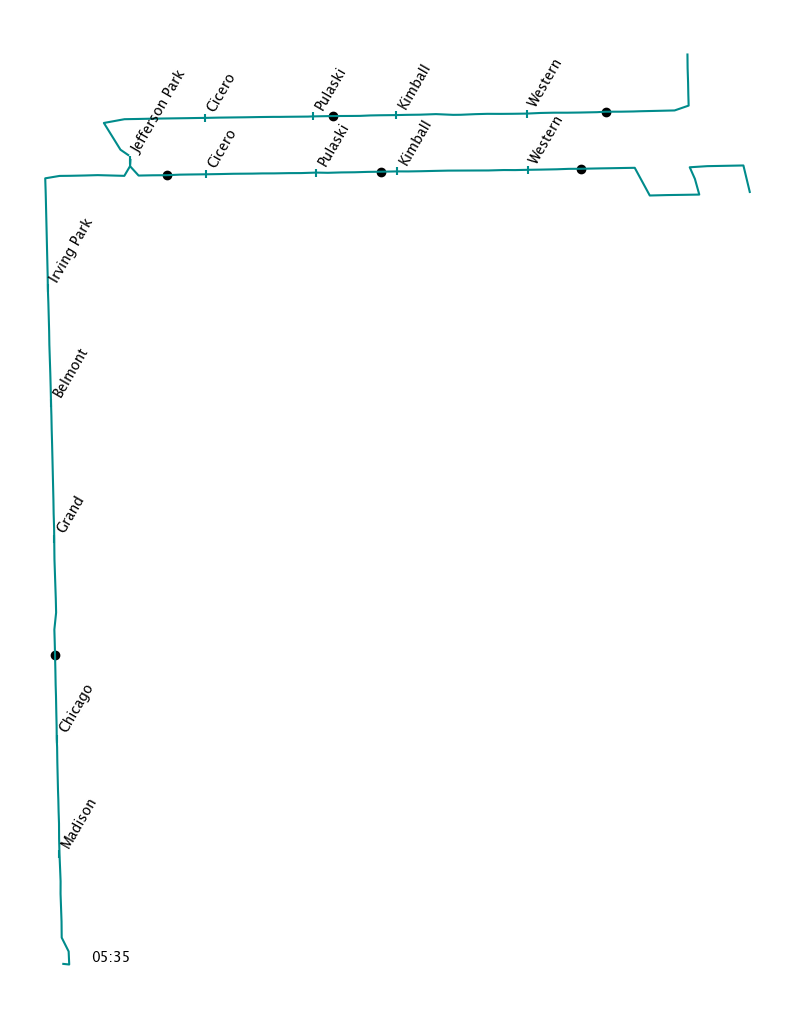

In [22]:
plot_situation(full_info, stops, env.hist_date)